In [2]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy import optimize
from matplotlib.ticker import FormatStrFormatter

In [3]:
sdir = '/Users/thepoetoftwilight/Documents/SOFIA_FIFI_Cycle-8/Data/NGC_7314_sw_1/'

savedir = '/Users/thepoetoftwilight/Documents/SOFIA_FIFI_Cycle-8/Data/NGC_7314_sw_1/Spectra/'

if not os.path.exists(savedir):
    os.makedirs(savedir)

fits_name = 'NGC_7314_sw_1.fits'

In [4]:
hdulist = fits.open(sdir + fits_name)

hdulist.info()

Filename: /Users/thepoetoftwilight/Documents/SOFIA_FIFI_Cycle-8/Data/NGC_7314_sw_1/NGC_7314_sw_1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     336   ()      
  1  FLUX          1 ImageHDU        28   (29, 27, 61)   float64   
  2  ERROR         1 ImageHDU        28   (29, 27, 61)   float64   
  3  UNCORRECTED_FLUX    1 ImageHDU        28   (29, 27, 61)   float64   
  4  UNCORRECTED_ERROR    1 ImageHDU        28   (29, 27, 61)   float64   
  5  WAVELENGTH    1 ImageHDU         9   (61,)   float64   
  6  X             1 ImageHDU         9   (29,)   float64   
  7  Y             1 ImageHDU         9   (27,)   float64   
  8  TRANSMISSION    1 ImageHDU         9   (61,)   float64   
  9  RESPONSE      1 ImageHDU         9   (61,)   float64   
 10  EXPOSURE_MAP    1 ImageHDU        28   (29, 27, 61)   float64   
 11  UNSMOOTHED_TRANSMISSION    1 ImageHDU        10   (1529, 2)   float64   


In [5]:
hdulist[1].header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -64 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                   29                                                  
NAXIS2  =                   27                                                  
NAXIS3  =                   61                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
DATE-OBS= '2019-11-13T03:21:08' / Observation date                              
BUNIT   = 'Jy/pixel'           / Data units                                     
EQUINOX =               2000.0 / Coordinate equinox                             
CTYPE1  = 'RA---TAN'           / Axis 1 type and projection                     
CTYPE2  = 'DEC--TAN'        

In [6]:
wavelengths = hdulist[5].data

x_coords = hdulist[6].data
x_min = x_coords[0]
x_max = x_coords[len(x_coords)-1]

y_coords = hdulist[7].data
y_min = y_coords[0]
y_max = y_coords[len(y_coords)-1]

print(wavelengths)

wav_diff = []

for i in range(0, len(wavelengths)-1):
    wav_diff.append(wavelengths[i+1]-wavelengths[i])
  
wav_diff = np.average(wav_diff)

print(wav_diff)

[51.84870131 51.85577479 51.86284828 51.86992176 51.87699525 51.88406873
 51.89114222 51.89821571 51.90528919 51.91236268 51.91943616 51.92650965
 51.93358313 51.94065662 51.9477301  51.95480359 51.96187707 51.96895056
 51.97602404 51.98309753 51.99017101 51.9972445  52.00431798 52.01139147
 52.01846495 52.02553844 52.03261192 52.03968541 52.04675889 52.05383238
 52.06090586 52.06797935 52.07505283 52.08212632 52.0891998  52.09627329
 52.10334677 52.11042026 52.11749374 52.12456723 52.13164071 52.1387142
 52.14578768 52.15286117 52.15993465 52.16700814 52.17408162 52.18115511
 52.18822859 52.19530208 52.20237556 52.20944905 52.21652254 52.22359602
 52.23066951 52.23774299 52.24481648 52.25188996 52.25896345 52.26603693
 52.27311042]
0.007073485114264007


In [7]:
# wavelength is the first dimension
# y is the second dimension
# x is the third dimension

fluxmaps = hdulist[1].data

fluxmaps_min = np.nanmin(fluxmaps.flatten())
fluxmaps_max = np.nanmax(fluxmaps.flatten())

print(fluxmaps.shape)

(61, 27, 29)


In [8]:
def sum_spaxel(fluxmap, k_x, k_y):
    
    n_x = len(fluxmap[0])
    n_y = len(fluxmap)
    
    id_x = np.arange(np.floor((n_x-k_x)/2), np.floor((n_x-k_x)/2) + k_x, 1)
    id_x = id_x.astype(int)
    
    id_y = np.arange(np.floor((n_y-k_y)/2), np.floor((n_y-k_y)/2) + k_y, 1)
    id_y = id_y.astype(int)
    
    central_fluxmap = []
    
    for j in id_y:
        
        y_snip = []
        
        for i in id_x:
            
            y_snip.append(fluxmap[j][i])
            
        central_fluxmap.append(y_snip)
            
    central_fluxmap = np.array(central_fluxmap)
    
    central_flux = np.sum(central_fluxmap)
    
    return central_flux

In [9]:
central_fluxes_unfiltered = []

n_x = 5
n_y = 5

for fluxmap in fluxmaps:
    
    central_flux_unfiltered = sum_spaxel(fluxmap, n_x, n_y)
    central_fluxes_unfiltered.append(central_flux_unfiltered)
    
central_fluxes_unfiltered = [flux*(10**(-26)) for flux in central_fluxes_unfiltered]

c = 3*10**8

for i in range(0, len(wavelengths)):
    
    wavelength = wavelengths[i]
    
    central_fluxes_unfiltered[i] = central_fluxes_unfiltered[i]*(c/(wavelength*10**(-6))**2)*(10**(-6))
    
central_fluxes_unfiltered = np.array(central_fluxes_unfiltered)

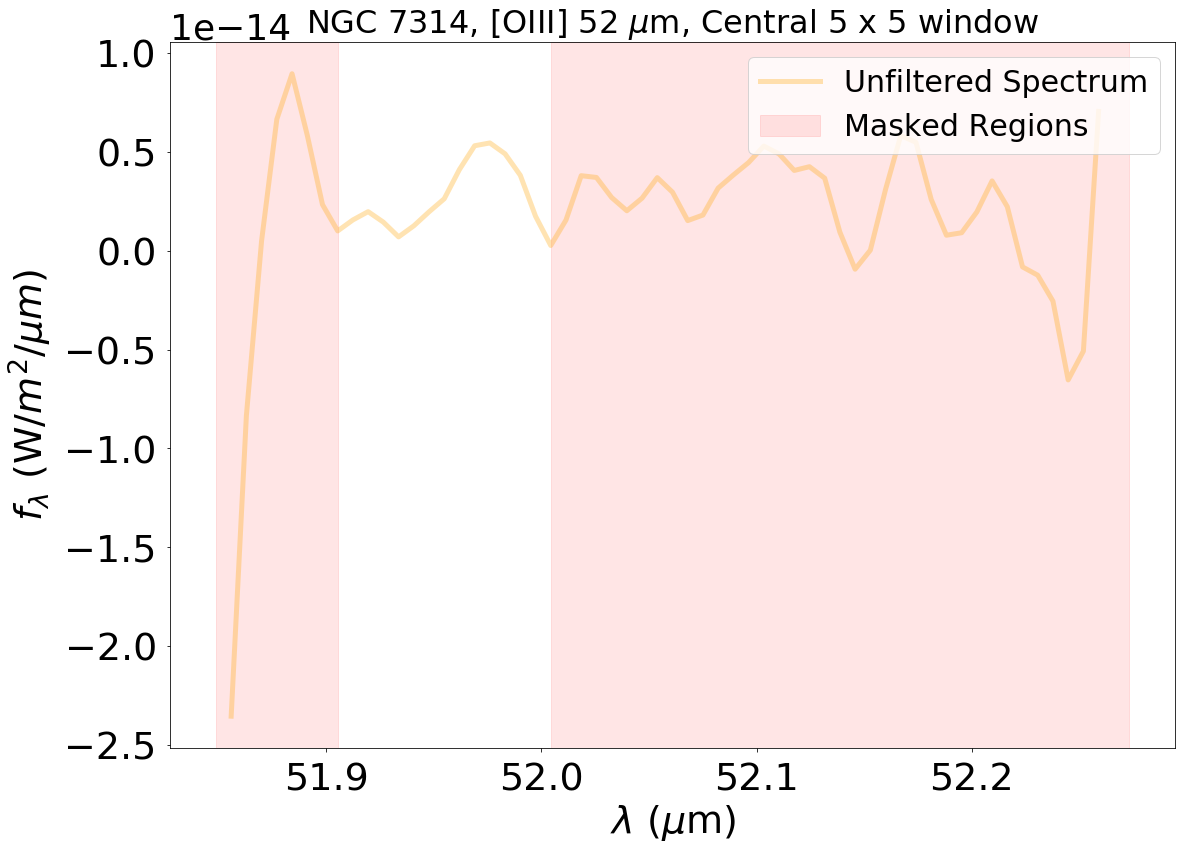

In [17]:
fig, ax = plt.subplots(figsize = (18, 13))

ax.plot(wavelengths, central_fluxes_unfiltered, label = 'Unfiltered Spectrum', lw = 5, color = 'orange', alpha = 0.3)
ax.axvspan(wavelengths[0], wavelengths[8], color = 'red', alpha = 0.1, label = 'Masked Regions')
ax.axvspan(wavelengths[22], wavelengths[-1], color = 'red', alpha = 0.1)

ax.set_xlabel(r'$\lambda$ ($\mu$m)', fontsize = 38, labelpad = 5)
ax.set_ylabel(r'$f_{\lambda}$ (W/$m^{2}$/$\mu m$)', fontsize = 38, labelpad = 10)
ax.set_title(r'NGC 7314, [OIII] 52 $\mu$m, Central {0} x {1} window'.format(n_x, n_y), fontsize = 32)
ax.ticklabel_format(axis = 'y', style = 'sci', scilimits = (0, 0))
ax.tick_params(labelsize = 38, pad = 10)
ax.yaxis.offsetText.set_fontsize(36)

plt.savefig(savedir + 'NGC_7314_[OIII]-1-unfiltered_spectrum.png'.format(str(n_x), str(n_y)))

ax.legend(prop={'size': 30}, loc = 'upper right')

In [18]:
print(central_fluxes_unfiltered)

[            nan -2.35341197e-14 -8.33850163e-15  5.05205600e-16
  6.64026282e-15  8.93952246e-15  5.83325838e-15  2.32585686e-15
  9.94144821e-16  1.55064806e-15  1.96870315e-15  1.43835395e-15
  6.93205038e-16  1.25168288e-15  1.95780225e-15  2.61859305e-15
  4.09928159e-15  5.29985023e-15  5.44181632e-15  4.88984274e-15
  3.80545346e-15  1.73785408e-15  2.57694439e-16  1.54383112e-15
  3.78681966e-15  3.69741906e-15  2.68427398e-15  2.01382072e-15
  2.65069485e-15  3.68831476e-15  2.95279229e-15  1.51637599e-15
  1.79687681e-15  3.15920070e-15  3.82186074e-15  4.45065912e-15
  5.28377227e-15  4.88832972e-15  4.05138811e-15  4.24138374e-15
  3.66136237e-15  9.29542400e-16 -9.40622401e-16  2.13598823e-17
  3.09242063e-15  5.81693496e-15  5.47027213e-15  2.58646412e-15
  7.77082664e-16  9.02216058e-16  1.95482202e-15  3.52256510e-15
  2.21819560e-15 -8.24545545e-16 -1.24406285e-15 -2.55574055e-15
 -6.53776141e-15 -5.08285294e-15  7.03661433e-15             nan
             nan]


In [19]:
central_fluxes_filtered = central_fluxes_unfiltered

wavelengths_filtered = wavelengths[8:23]
central_fluxes_filtered = central_fluxes_filtered[8:23]

print(central_fluxes_filtered)

[9.94144821e-16 1.55064806e-15 1.96870315e-15 1.43835395e-15
 6.93205038e-16 1.25168288e-15 1.95780225e-15 2.61859305e-15
 4.09928159e-15 5.29985023e-15 5.44181632e-15 4.88984274e-15
 3.80545346e-15 1.73785408e-15 2.57694439e-16]


In [22]:
central_fluxes_filtered_continuum = []

left_cut = 51.94
right_cut = 52.00

for i in range(0, len(wavelengths_filtered)):
    
    wavelength = wavelengths_filtered[i]
    
    if(wavelength < left_cut or wavelength > right_cut):
        central_fluxes_filtered_continuum.append(central_fluxes_filtered[i])
    
    else:
        central_fluxes_filtered_continuum.append(float("Nan"))
        
central_fluxes_filtered_continuum = np.array(central_fluxes_filtered_continuum)

print(central_fluxes_filtered_continuum)

[9.94144821e-16 1.55064806e-15 1.96870315e-15 1.43835395e-15
 6.93205038e-16            nan            nan            nan
            nan            nan            nan            nan
            nan            nan 2.57694439e-16]


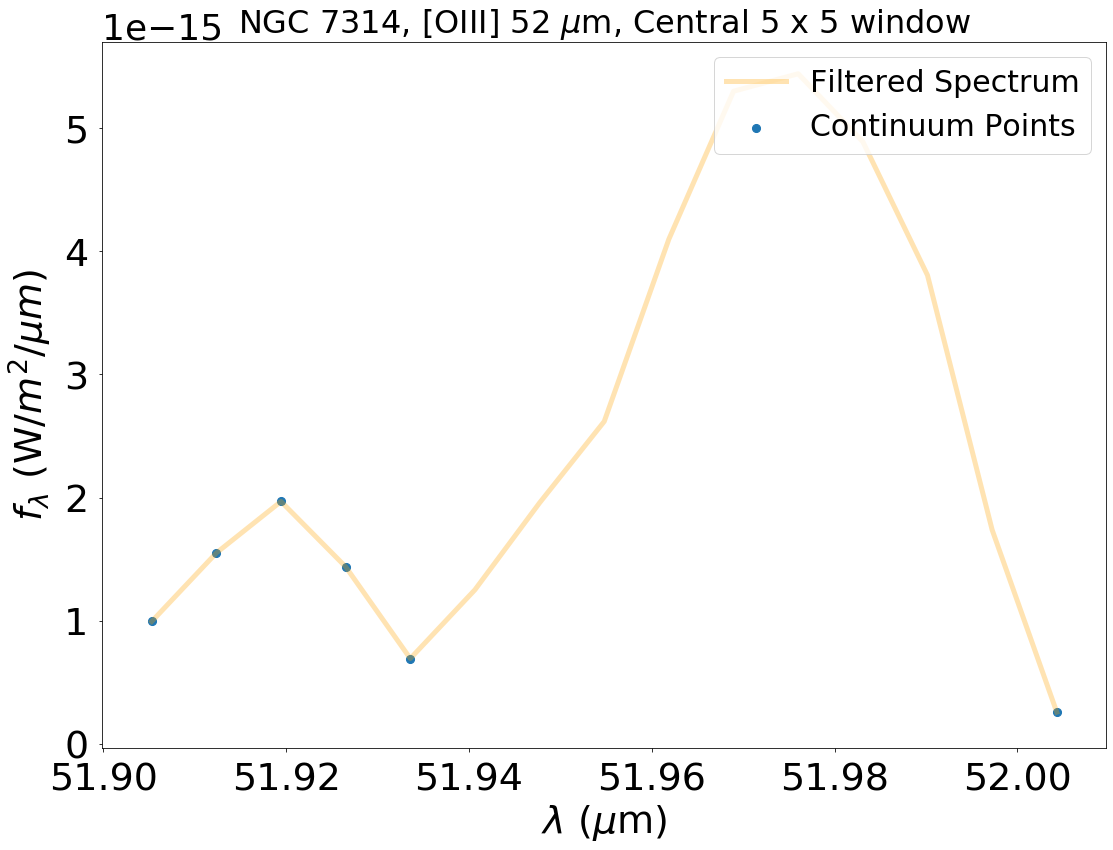

In [23]:
fig, ax = plt.subplots(figsize = (18, 13))

ax.plot(wavelengths_filtered, central_fluxes_filtered, label = 'Filtered Spectrum', lw = 5, color = 'orange', alpha = 0.3)
ax.scatter(wavelengths_filtered, central_fluxes_filtered_continuum, s = 65, label = 'Continuum Points')

ax.set_xlabel(r'$\lambda$ ($\mu$m)', fontsize = 38, labelpad = 5)
ax.set_ylabel(r'$f_{\lambda}$ (W/$m^{2}$/$\mu m$)', fontsize = 38, labelpad = 10)
ax.set_title(r'NGC 7314, [OIII] 52 $\mu$m, Central {0} x {1} window'.format(n_x, n_y), fontsize = 32)
ax.ticklabel_format(axis = 'y', style = 'sci', scilimits = (0, 0))
ax.tick_params(labelsize = 38, pad = 10)
ax.yaxis.offsetText.set_fontsize(36)

ax.legend(prop={'size': 30}, loc = 'upper right')

plt.savefig(savedir + 'NGC_7314_[OIII]-2-filtered_spectrum + continuum_points.png'.format(str(n_x), str(n_y)))

In [24]:
idcont = np.isfinite(central_fluxes_filtered_continuum)
cont_params = np.polyfit(wavelengths_filtered[idcont], central_fluxes_filtered_continuum[idcont], 1)

print(cont_params)

cont_line_filtered = cont_params[0]*wavelengths_filtered + cont_params[1]

[-1.24270581e-14  6.46532111e-13]


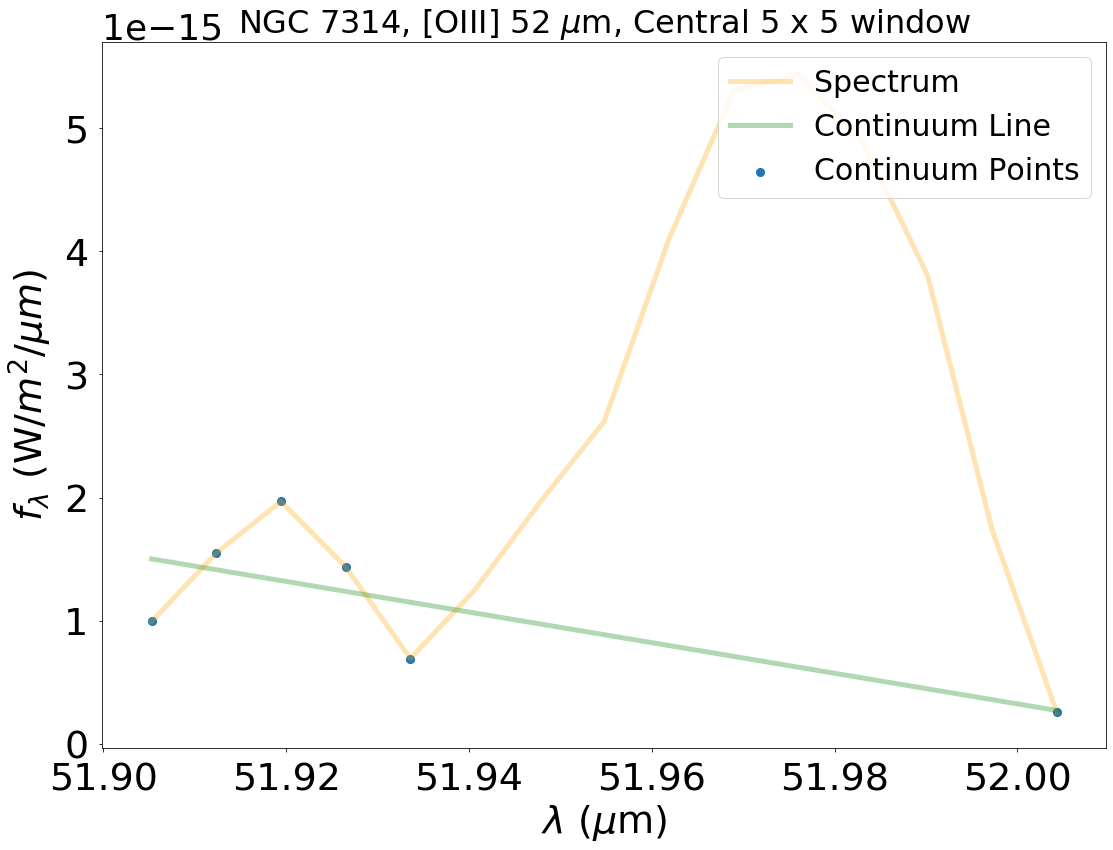

In [25]:
fig, ax = plt.subplots(figsize = (18, 13))

ax.plot(wavelengths_filtered, central_fluxes_filtered, label = 'Spectrum', lw = 5, color = 'orange', alpha = 0.3)
ax.plot(wavelengths_filtered, cont_line_filtered, label = 'Continuum Line', lw = 5, color = 'green', alpha = 0.3)
ax.scatter(wavelengths_filtered, central_fluxes_filtered_continuum, s = 65, label = 'Continuum Points')

ax.set_xlabel(r'$\lambda$ ($\mu$m)', fontsize = 38, labelpad = 5)
ax.set_ylabel(r'$f_{\lambda}$ (W/$m^{2}$/$\mu m$)', fontsize = 38, labelpad = 10)
ax.set_title(r'NGC 7314, [OIII] 52 $\mu$m, Central {0} x {1} window'.format(n_x, n_y), fontsize = 32)
ax.ticklabel_format(axis='y', style='sci', scilimits = (0, 0))
ax.tick_params(labelsize = 38, pad = 10)
ax.yaxis.offsetText.set_fontsize(36)

ax.legend(prop={'size': 30}, loc = 'upper right')

plt.savefig(savedir + 'NGC_7314_[OIII]-3-filtered_spectrum + continuum_line.png'.format(str(n_x), str(n_y)))

In [26]:
id_act = np.isnan(central_fluxes_filtered_continuum)

wavelengths_act = wavelengths_filtered[id_act]
central_fluxes_filtered_act = central_fluxes_filtered[id_act]
cont_line_filtered_act = cont_line_filtered[id_act]

central_fluxes_continuum_subtracted_act = central_fluxes_filtered_act - cont_line_filtered_act

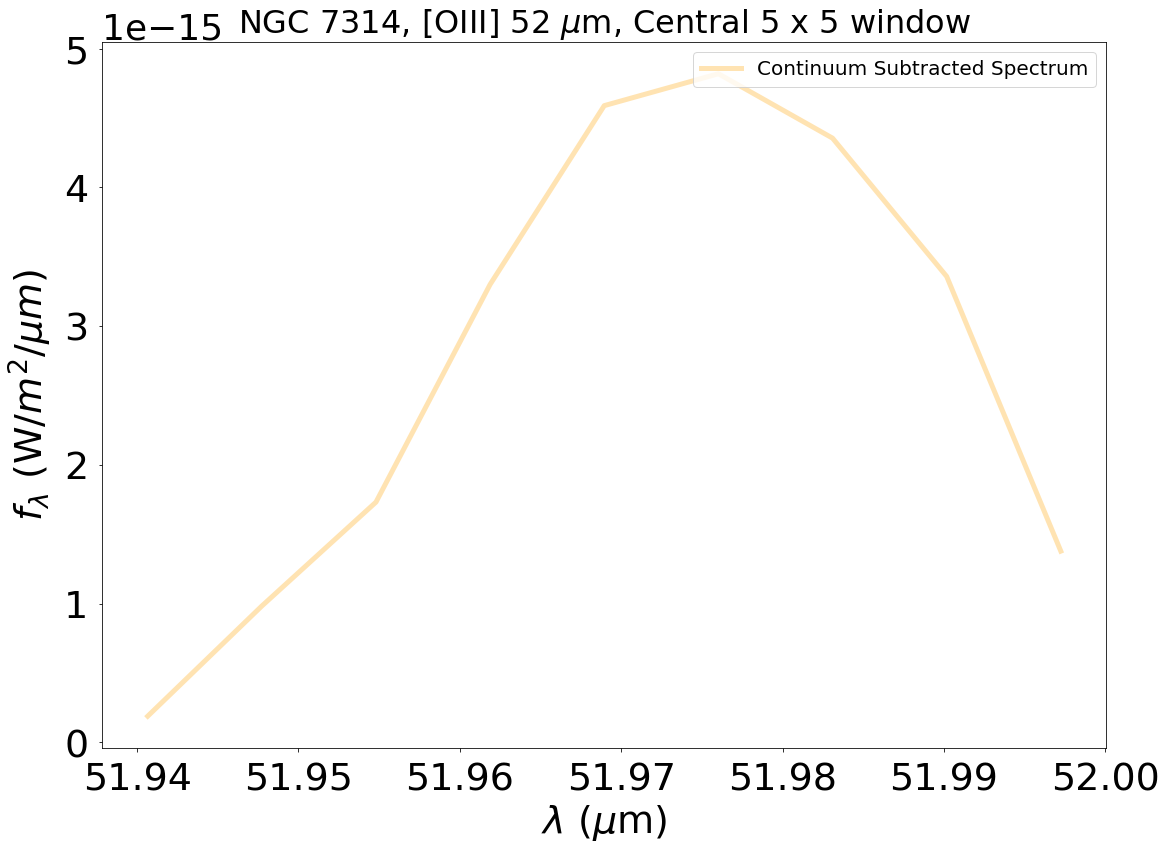

In [27]:
fig, ax = plt.subplots(figsize = (18, 13))

ax.plot(wavelengths_act, central_fluxes_continuum_subtracted_act, label = 'Continuum Subtracted Spectrum', lw = 5, color = 'orange', alpha = 0.3)

ax.set_xlabel(r'$\lambda$ ($\mu$m)', fontsize = 38, labelpad = 5)
ax.set_ylabel(r'$f_{\lambda}$ (W/$m^{2}$/$\mu m$)', fontsize = 38, labelpad = 10)
ax.set_title(r'NGC 7314, [OIII] 52 $\mu$m, Central {0} x {1} window'.format(n_x, n_y), fontsize = 32)
ax.ticklabel_format(axis='y', style='sci', scilimits = (0, 0))
ax.tick_params(labelsize = 38, pad = 10)
ax.yaxis.offsetText.set_fontsize(36)

ax.legend(prop={'size': 20}, loc = 'upper right')

plt.savefig(savedir + 'NGC_7314_[OIII]-4-continuum_subtracted_spectrum.png'.format(str(n_x), str(n_y)))

In [28]:
def fit_func_1(Z, peak_height, mu, sigma):
    
    P = peak_height*np.exp(-((Z-mu)**2/(2*sigma**2)))
    
    return P

In [29]:
heights = central_fluxes_continuum_subtracted_act/np.max(central_fluxes_continuum_subtracted_act)

centers = wavelengths_act

# Information about the peak in the numerical PDF
peak_ind = np.where(heights == np.max(heights))[0][0]
peak_height = np.max(heights)

# mu is where the numerical PDF peaks
mu = centers[peak_ind]

# Estimating sigma using FWHM
sigma = 0

for i in range(0, peak_ind):
    if(heights[i] >= peak_height/2):
        sigma = (mu - centers[i])/np.sqrt(2*np.log(2))
        break

# First fit a Gaussian

guess_params = np.array([peak_height, sigma])
fit_params, fit_covar = optimize.curve_fit(lambda centers, peak_height, sigma: 
                                           fit_func_1(centers, peak_height, mu, sigma), 
                                           centers, heights, p0=guess_params)

fit_params = [fit_params[0], mu, fit_params[1]]

fit_params[0] *= np.max(central_fluxes_continuum_subtracted_act)

print(fit_params)

[4.982999565681174e-15, 51.97602404129786, 0.014738851788725903]


[2.79984634e-16 3.28731467e-16 3.84192740e-16 4.46948853e-16
 5.17567856e-16 5.96592188e-16 6.84523914e-16 7.81808672e-16
 8.88818609e-16 1.00583465e-15 1.13302851e-15 1.27044504e-15
 1.41798529e-15 1.57539101e-15 1.74223124e-15 1.91789147e-15
 2.10156610e-15 2.29225473e-15 2.48876275e-15 2.68970664e-15
 2.89352426e-15 3.09849028e-15 3.30273663e-15 3.50427795e-15
 3.70104142e-15 3.89090064e-15 4.07171276e-15 4.24135790e-15
 4.39778006e-15 4.53902827e-15 4.66329688e-15 4.76896395e-15
 4.85462637e-15 4.91913088e-15 4.96159991e-15 4.98145144e-15
 4.97841227e-15 4.95252426e-15 4.90414341e-15 4.83393167e-15
 4.74284192e-15 4.63209640e-15 4.50315945e-15 4.35770530e-15
 4.19758197e-15 4.02477225e-15 3.84135312e-15 3.64945447e-15
 3.45121857e-15 3.24876109e-15 3.04413482e-15 2.83929676e-15
 2.63607940e-15 2.43616660e-15 2.24107441e-15 2.05213708e-15
 1.87049802e-15]


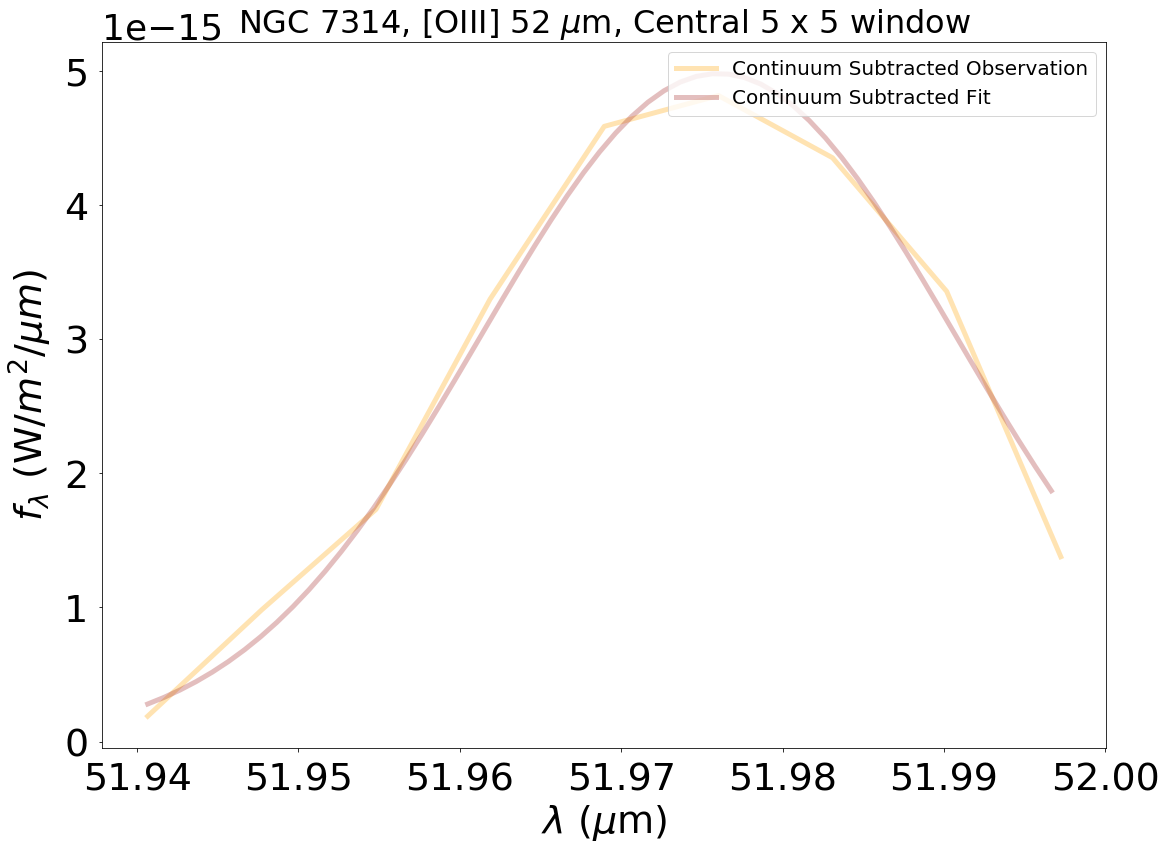

In [30]:
fig, ax = plt.subplots(figsize = (18, 13))

wavelength_range = np.arange(np.min(wavelengths_act), np.max(wavelengths_act), 0.001)

fitted_central_fluxes_continuum_subtracted_act = fit_func_1(wavelength_range, *fit_params)

print(fitted_central_fluxes_continuum_subtracted_act)

ax.plot(wavelengths_act, central_fluxes_continuum_subtracted_act, 
        label = 'Continuum Subtracted Observation', lw = 5, color = 'orange', alpha = 0.3)

ax.plot(wavelength_range, fitted_central_fluxes_continuum_subtracted_act, 
        label = 'Continuum Subtracted Fit', lw = 5, color = 'brown', alpha = 0.3)


ax.set_xlabel(r'$\lambda$ ($\mu$m)', fontsize = 38, labelpad = 5)
ax.set_ylabel(r'$f_{\lambda}$ (W/$m^{2}$/$\mu m$)', fontsize = 38, labelpad = 10)
ax.set_title(r'NGC 7314, [OIII] 52 $\mu$m, Central {0} x {1} window'.format(n_x, n_y), fontsize = 32)
ax.ticklabel_format(axis='y', style='sci', scilimits = (0, 0))
ax.tick_params(labelsize = 38, pad = 10)
ax.yaxis.offsetText.set_fontsize(36)

ax.legend(prop={'size': 20}, loc = 'upper right')

plt.savefig(savedir + 'NGC_7314_[OIII]-5-fit_continuum_subtracted_spectrum.png'.format(str(n_x), str(n_y)))

[2.79984634e-16 3.28731467e-16 3.84192740e-16 4.46948853e-16
 5.17567856e-16 5.96592188e-16 6.84523914e-16 7.81808672e-16
 8.88818609e-16 1.00583465e-15 1.13302851e-15 1.27044504e-15
 1.41798529e-15 1.57539101e-15 1.74223124e-15 1.91789147e-15
 2.10156610e-15 2.29225473e-15 2.48876275e-15 2.68970664e-15
 2.89352426e-15 3.09849028e-15 3.30273663e-15 3.50427795e-15
 3.70104142e-15 3.89090064e-15 4.07171276e-15 4.24135790e-15
 4.39778006e-15 4.53902827e-15 4.66329688e-15 4.76896395e-15
 4.85462637e-15 4.91913088e-15 4.96159991e-15 4.98145144e-15
 4.97841227e-15 4.95252426e-15 4.90414341e-15 4.83393167e-15
 4.74284192e-15 4.63209640e-15 4.50315945e-15 4.35770530e-15
 4.19758197e-15 4.02477225e-15 3.84135312e-15 3.64945447e-15
 3.45121857e-15 3.24876109e-15 3.04413482e-15 2.83929676e-15
 2.63607940e-15 2.43616660e-15 2.24107441e-15 2.05213708e-15
 1.87049802e-15]


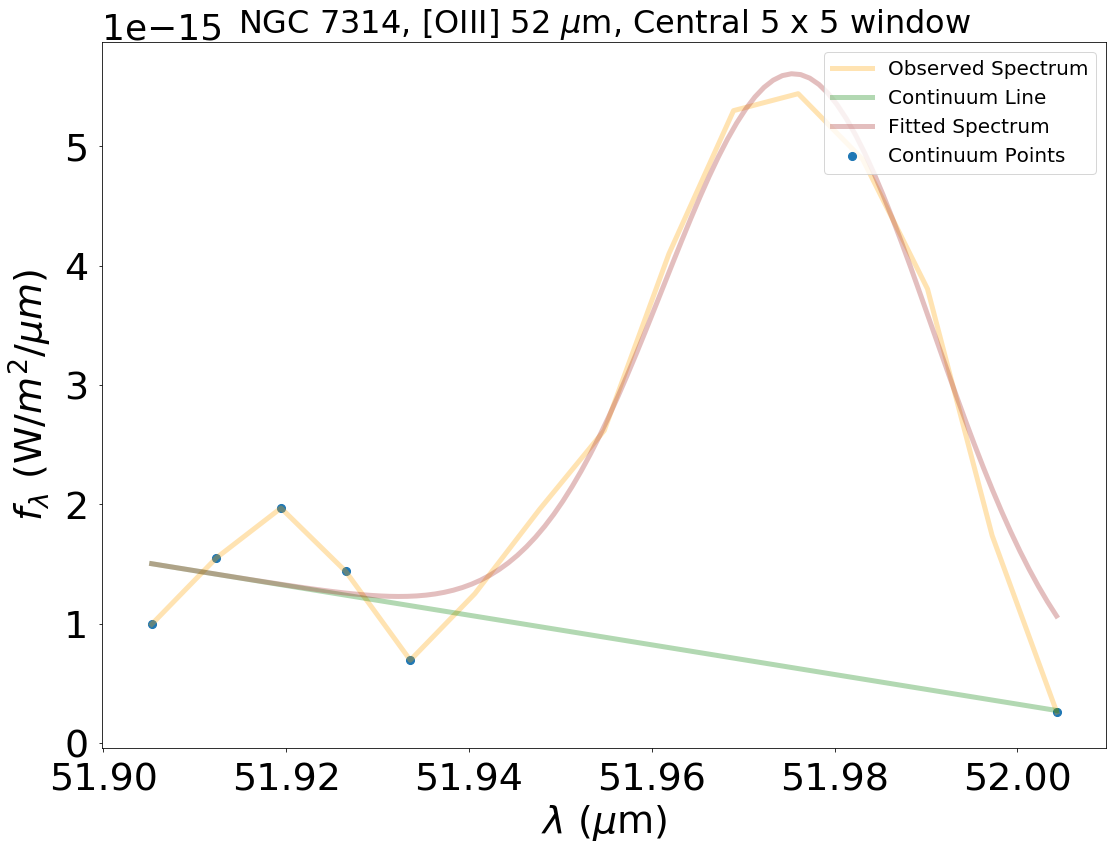

In [31]:
fig, ax = plt.subplots(figsize = (18, 13))

wavelength_range = np.arange(np.min(wavelengths_filtered), np.max(wavelengths_filtered), 0.001)
cont_line_filtered = cont_params[0]*wavelength_range + cont_params[1]

fitted_central_fluxes_act = fit_func_1(wavelength_range, *fit_params) + cont_line_filtered

print(fitted_central_fluxes_continuum_subtracted_act)

ax.plot(wavelengths_filtered, central_fluxes_filtered, label = 'Observed Spectrum', lw = 5, color = 'orange', alpha = 0.3)
ax.plot(wavelength_range, cont_line_filtered, label = 'Continuum Line', lw = 5, color = 'green', alpha = 0.3)
ax.plot(wavelength_range, fitted_central_fluxes_act, label = 'Fitted Spectrum', lw = 5, color = 'brown', alpha = 0.3)
ax.scatter(wavelengths_filtered, central_fluxes_filtered_continuum, s = 65, label = 'Continuum Points')

ax.set_xlabel(r'$\lambda$ ($\mu$m)', fontsize = 38, labelpad = 5)
ax.set_ylabel(r'$f_{\lambda}$ (W/$m^{2}$/$\mu m$)', fontsize = 38, labelpad = 10)
ax.set_title(r'NGC 7314, [OIII] 52 $\mu$m, Central {0} x {1} window'.format(n_x, n_y), fontsize = 32)
ax.ticklabel_format(axis='y', style='sci', scilimits = (0, 0))
ax.tick_params(labelsize = 38, pad = 10)
ax.yaxis.offsetText.set_fontsize(36)

ax.legend(prop={'size': 20}, loc = 'upper right')

plt.savefig(savedir + 'NGC_7314_[OIII]-6-final_spectrum.png'.format(str(n_x), str(n_y)))

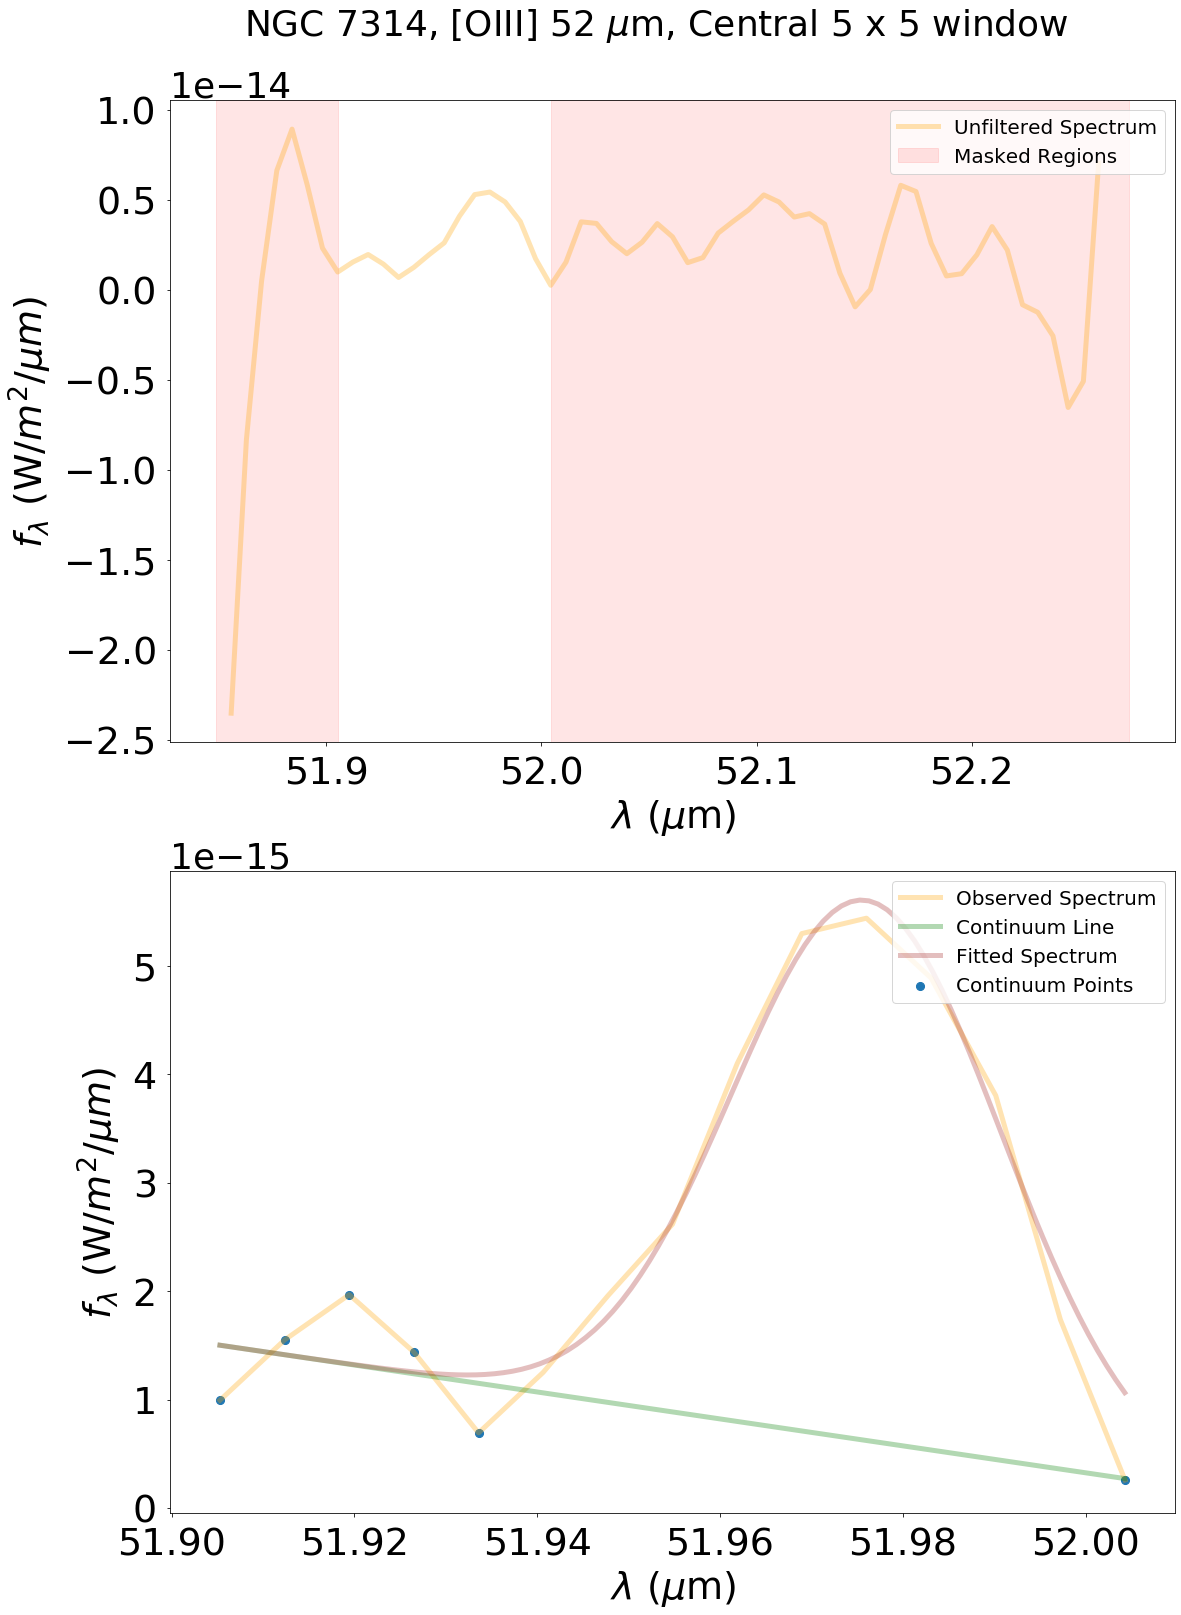

In [33]:
fig, axs = plt.subplots(2, 1, figsize = (18, 26))

ax1 = axs[0]

ax1.plot(wavelengths, central_fluxes_unfiltered, label = 'Unfiltered Spectrum', lw = 5, color = 'orange', alpha = 0.3)
ax1.axvspan(wavelengths[0], wavelengths[8], color = 'red', alpha = 0.1, label = 'Masked Regions')
ax1.axvspan(wavelengths[22], wavelengths[-1], color = 'red', alpha = 0.1)

ax1.set_xlabel(r'$\lambda$ ($\mu$m)', fontsize = 38, labelpad = 5)
ax1.set_ylabel(r'$f_{\lambda}$ (W/$m^{2}$/$\mu m$)', fontsize = 38, labelpad = 10)
ax1.tick_params(labelsize = 38, pad = 10)
ax1.yaxis.offsetText.set_fontsize(36)
ax1.legend(prop={'size': 20}, loc = 'upper right')

ax2 = axs[1]

ax2.plot(wavelengths_filtered, central_fluxes_filtered, label = 'Observed Spectrum', lw = 5, color = 'orange', alpha = 0.3)
ax2.plot(wavelength_range, cont_line_filtered, label = 'Continuum Line', lw = 5, color = 'green', alpha = 0.3)
ax2.plot(wavelength_range, fitted_central_fluxes_act, label = 'Fitted Spectrum', lw = 5, color = 'brown', alpha = 0.3)
ax2.scatter(wavelengths_filtered, central_fluxes_filtered_continuum, s = 65, label = 'Continuum Points')

ax2.set_xlabel(r'$\lambda$ ($\mu$m)', fontsize = 38, labelpad = 5)
ax2.set_ylabel(r'$f_{\lambda}$ (W/$m^{2}$/$\mu m$)', fontsize = 38, labelpad = 10)
ax2.tick_params(labelsize = 38, pad = 10)
ax2.yaxis.offsetText.set_fontsize(36)
ax2.legend(prop={'size': 20}, loc = 'upper right')

fig.suptitle(r'NGC 7314, [OIII] 52 $\mu$m, Central {0} x {1} window'.format(n_x, n_y), fontsize = 36, y = 0.93)

plt.savefig(savedir + 'NGC_7314_[OIII]-7-summary_spectrum.png'.format(str(n_x), str(n_y)))

In [34]:
flux_continuum = np.trapz(cont_line_filtered, x = wavelength_range, dx = wav_diff)

flux_obs = np.trapz(central_fluxes_filtered, x = wavelengths_filtered, dx = wav_diff)
flux_obs_sub = flux_obs - flux_continuum
print('Flux of the continuum subtracted observation = ' + str(flux_obs_sub) + ' W/m^2')

flux_fit = np.trapz(fitted_central_fluxes_act, x = wavelength_range, dx = wav_diff)
flux_fit_sub = flux_fit - flux_continuum
print('Flux of the continuum subtracted fit = ' + str(flux_fit_sub) + ' W/m^2')

print('Spectral width = ' + str(str(2*np.sqrt(np.log(2))*fit_params[2])) + r' microns')

Flux of the continuum subtracted observation = 1.7659384385121386e-16 W/m^2
Flux of the continuum subtracted fit = 1.7901129374808343e-16 W/m^2
Spectral width = 0.02454179803974726 microns
